In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
from sklearn.model_selection import train_test_split
import data_utils_cnn as data_utils
from Constants_cnn import *
from IPython.display import clear_output
import seaborn as sn

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, LSTM, GRU, Conv1d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, CrossEntropyLoss, BCELoss
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [3]:
from scipy import signal

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

## Collecting the data

In [5]:
def build_poly(X, Y):
    P = np.array([X**2, Y**2, X, Y, X*Y, X*0+1]).T
    return P

def px2CalibedDeg(gaze_x_px, gaze_y_px, cX, cY, PIpx2deg_cX, PIpx2deg_cY):
    
    #calib to correct px
    P = build_poly(gaze_x_px, gaze_y_px)

    gaze_x_px_calib = np.dot(P, cX)
    gaze_y_px_calib = np.dot(P, cY)

    #calibed px to deg
    P = build_poly(gaze_x_px_calib, gaze_y_px_calib)

    gaze_x_deg_calib = np.dot(P, PIpx2deg_cX)
    gaze_y_deg_calib = np.dot(P, PIpx2deg_cY)
    
    return gaze_x_px_calib, gaze_y_px_calib, gaze_x_deg_calib, gaze_y_deg_calib


def readGazePos (filename, _format = '<f'):
    values = []
    blocksize = calcsize(_format)
    with open(filename, "rb") as f:
        while True:
            buf = f.read(blocksize)
            if not buf:
                break
            values.append(unpack(_format, buf))

    values = np.array(values)
    
    values = values.reshape((int(len(values)/2),2))
    
    return values

def readGazeTimstamp (filename, _format = '<Q'):
    values = []
    blocksize = calcsize(_format)
    with open(filename, "rb") as f:
        while True:
            buf = f.read(blocksize)
            if not buf:
                break
            values.append(unpack(_format, buf))

    values = np.array(values).squeeze()
    
    #values = values.reshape((int(len(values)/2),2))
    
    return values

#load in precalculated converstion matrix
PIpx2deg_cX = pickle.load(open('/data/IBOSTesting/PIDataCalibrated_new/PIPx2Deg/PIpx2deg_cX.pkl', 'rb'))
PIpx2deg_cY = pickle.load(open('/data/IBOSTesting/PIDataCalibrated_new/PIPx2Deg/PIpx2deg_cY.pkl', 'rb'))

#parent folder for calibraiton matrix
PICalibFolder = '/data/IBOSTesting/PIDataCalibrated_new/Analysis/_jeff_diako_train_fiona_test/'

### load gaze data for 1 participant (test)
gaze_x_deg_calib is the calibrated gaze horizontal visual angle <br>
gaze_x_deg_calib is the calibrated gaze vertical visual angle <br>
gazeTime is timestamp (s)

In [6]:
#define subID and taskFolder, all you gotta change
subID = 'P2'
taskFolder = 'P2_cereal_2021-08-13-13-54-10'


def get_vector(subID, taskFolder):
    
    #define parent folder, handles itself, dont have to change
    recordingFolder = '/data/IBOSTesting/PIDataCalibrated_new/{subID}/{taskFolder}/'.format(subID=subID, taskFolder=taskFolder)

    #load gaze position (px)
    gazePosPath = recordingFolder + 'gaze ps1.raw'
    gazePos = readGazePos(gazePosPath)

    #load calibration matrix
    cX = pickle.load(open(PICalibFolder + 'test{subID}/cX.pkl'.format(subID = subID), 'rb'))
    cY = pickle.load(open(PICalibFolder + 'test{subID}/cY.pkl'.format(subID = subID), 'rb'))

    #convert gaze position from original px to calibrated px and deg
    gaze_x_px = gazePos[:,0]
    gaze_y_px = gazePos[:,1]

    gaze_x_px_calib, gaze_y_px_calib, gaze_x_deg_calib, gaze_y_deg_calib = px2CalibedDeg(gaze_x_px, gaze_y_px, cX, cY, PIpx2deg_cX, PIpx2deg_cY)


    #load gaze timestamp(ns -> s)
    gazeTimeStampPath = recordingFolder + 'gaze ps1.time'
    gazeTime = readGazeTimstamp(gazeTimeStampPath) / 1000000000

    return gazeTime, gazePos, gaze_x_deg_calib, gaze_y_deg_calib


gazeTime, gazePos, gaze_x_deg_calib, gaze_y_deg_calib = get_vector(subID, taskFolder)

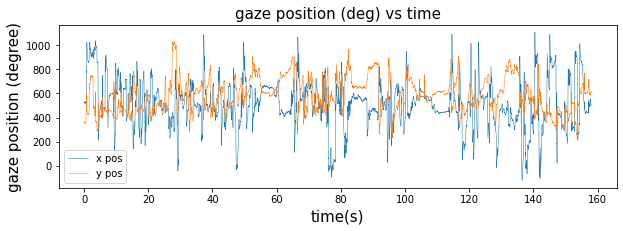

In [7]:
#visualize original px gaze position
plt.figure(figsize=(10, 3))
plt.plot(gazeTime-gazeTime[0], gazePos[:,0], linewidth = 0.5, label = 'x pos')
plt.plot(gazeTime-gazeTime[0], gazePos[:,1], linewidth = 0.5, label = 'y pos')
plt.title('gaze position (deg) vs time', fontsize = 15)
plt.xlabel('time(s)', fontsize = 15)
plt.ylabel('gaze position (degree)', fontsize = 15)
plt.legend()
plt.show()

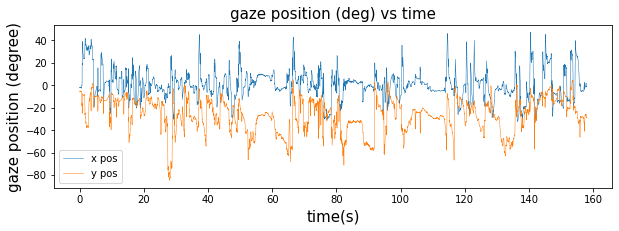

In [8]:
#visualize converted deg gaze position
plt.figure(figsize=(10, 3))
plt.plot(gazeTime-gazeTime[0], gaze_x_deg_calib, linewidth = 0.5, label = 'x pos')
plt.plot(gazeTime-gazeTime[0], gaze_y_deg_calib, linewidth = 0.5, label = 'y pos')
plt.title('gaze position (deg) vs time', fontsize = 15)
plt.xlabel('time(s)', fontsize = 15)
plt.ylabel('gaze position (degree)', fontsize = 15)
plt.legend()
plt.show()

### Load gaze data for all participants
Also clear outliers and noise that are physiologically impossible, such as intersample velocity greater than 1000 deg/s and less than or equal to 0 deg/s (because velocity is actually magnitude in our case). Also remove data that is outside of the window frame.

In [9]:
def clean_data(df):
    """
    Takes in a dataframe and returns a subset that excludes rows with intersample velocity over 1000 deg/s.
    """
    assert 'isv' in list(df.columns), "'isv' is not a column in the dataframe"
    
    # Remove data where the intersample velocity is above the physiological threshold of 1000 deg/s (noise).
    bad_i = df[df['isv'] > 1000].index
    df_clean = df.drop(bad_i)
    
    # Remove data where the intersample velocity (magnitude) is less than or equal to 0 deg/s (noise).
    bad_i = df[df['isv'] <= 0].index
    df_clean = df_clean.drop(bad_i)

    # Reset the row indices in the new dataframe (for indexing purposes).
    df_clean.reset_index(drop=True, inplace=True)
    
    return df_clean


def standardize(x):
    """ 
    Z-Score normalization turns a distribution into a standard normal distribution
    with mean 0 and standard deviation 1.
    """
    z = (x-np.average(x))/np.std(x)
    return z

In [10]:
# All participants with a calibration folder and either PVL or CVL
participants = {'P2':'CVL', 'P3':'CVL', 'P5':'PVL', 'P6':'CVL', 'P8':'CVL', 'P9':'CVL',
                'P10':'CVL', 'P11':'PVL', 'P12':'PVL', 'P13':'CVL', 'P14':'PVL', 'P15':'PVL', 'P16':'PVL', 
                'P17':'PVL', 'P18':'CVL', 'P19':'CVL', 'P21':'CVL', 'P22':'PVL', 'P24':'PVL', 'P25':'CVL'}

tasks = []

# Take only valid datasets
isCalibBad = ['P3_sandwich', 'P3_cereal', 'P3_walk', 'P4_sandwich', 'P4_cereal', 'P4_walk', 'P11_sandwich',
             'P11_cereal', 'P11_walk', 'P13_sandwich', 'P13_cereal', 'P13_walk', 'P14_sandwich' 'P14_walk',
             'P16_sandwich', 'P18_sandwich', 'P18_cereal', 'P18_walk', 'P19_sandwich', 'P19_walk',
             'P21_sandwich', 'P21_walk']
maybe_isCalibBad = ['P12_sandwich', 'P12_cereal', 'P12_walk', 'P17_cereal', 'P17_walk', 'P25_cereal']
isOptimal = ['P6_walk', 'P14_cereal', 'P16_cereal', 'P16_walk', 'P17_sandwich', 'P19_cereal', 'P21_cereal',
            'P22_cereal', 'P22_walk', 'P24_cereal', 'P25_sandwich', 'P25_walk']

valid_participants = {}
for participant in participants.keys():
    recordingFolder = '/data/IBOSTesting/PIDataCalibrated_new/{subID}/'.format(subID=participant)
    if str(participant + '_cereal') in isCalibBad or str(participant + '_sandwich') in isCalibBad or str(participant + '_walk') in isCalibBad:
        continue
    if str(participant + '_cereal') in maybe_isCalibBad or str(participant + '_sandwich') in maybe_isCalibBad or str(participant + '_walk') in maybe_isCalibBad:
        continue
    for fname in os.listdir(recordingFolder):
#         if fname.startswith(str(participant + '_cereal')) and not fname.endswith('.mp4') and 'fail' not in fname and 'wrong' not in fname:
#             tasks.append(fname)
        if fname.startswith(str(participant + '_sandwich')) and not fname.endswith('.mp4') and 'fail' not in fname and 'wrong' not in fname:
            tasks.append(fname)
#         if fname.startswith(str(participant + '_walk')) and not fname.endswith('.mp4') and 'fail' not in fname and 'wrong' not in fname:
#             tasks.append(fname)
    if participant not in list(valid_participants.keys()):
        valid_participants[participant] = participants[participant]

print("Number of participants:", len(valid_participants))
print("Number of tasks across all participants:", len(tasks))
print("\n valid participants:", valid_participants)

Number of participants: 10
Number of tasks across all participants: 10

 valid participants: {'P2': 'CVL', 'P5': 'PVL', 'P6': 'CVL', 'P8': 'CVL', 'P9': 'CVL', 'P10': 'CVL', 'P14': 'PVL', 'P15': 'PVL', 'P22': 'PVL', 'P24': 'PVL'}


In [11]:
# This is only relevant when testing additional features from the experiment

testData = np.array([['P1', 'P2', 'P3', 'P5', 'P6', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
                      'P15', 'P16', 'P17', 'P18', 'P19', 'P21', 'P22', 'P23', 'P24', 'P25'],
                    [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
                    [87, 56, 75, 62, 58, 56, 54, 65, 103, 248, 54, 61, 113, 65, 55, 58, 60, 69, 55, 69, 82, 72],
                    [66, 36, 48, 43, 32, 33, 32, 37, 110, 167, 33, 43, 103, 45, 35, 35, 38, 44, 33, 43, 52, 41],
                    [1.6, 1.9, 1.4, 1.8, 1.5, 1.6, 2, 1.7, 1.1, 1., 1.6, 1.6, 1.8, 1.6, 1.5, 1.8, 1.4, 1.6, 0.8, 1., 1.6, 1.2],
                    [1.2, 1.7, 1.2, 1.6, 0.7, 0.8, 1.2, 1., 0.5, 0.5, 1.2, 1., 1.4, 1.2, 0.7, 1.3, 1.3, 1.3, 0.7, 1.1, 1.1, 0.8]])
testData = testData.transpose()
test = pd.DataFrame(testData, columns=['subID', 'vision_loss', 'steps_to_kitchen', 'sec_to_kitchen',
                                      'AMPS_motor_ADL', 'AMPS_process_ADL'])

# standardize the additional features
test['steps_to_kitchen'] = standardize(test['steps_to_kitchen'].astype("float").to_numpy())
test['sec_to_kitchen'] = standardize(test['sec_to_kitchen'].astype("float").to_numpy())
test['AMPS_motor_ADL'] = standardize(test['AMPS_motor_ADL'].astype("float").to_numpy())
test['AMPS_process_ADL'] = standardize(test['AMPS_process_ADL'].astype("float").to_numpy())

## Pre-process the Data

Data fields <br>
- subID: participant number
- task:  cereal, sandwich, or walk
- vl_type:    type of vision loss (0 = mixed or other, 1 = PVL, 2 = CVL)
- x_deg1, x_deg2, ..., x_deg132: each of the 132 attribute vectors for the x position feature
- y_deg1, y_deg2, ..., y_deg132: each of the 132 attribute vectors for the y position feature
- isd1, isd2, ..., isd132: each of the 132 attribute vectors for the intersample displacement feature
- isv1, isv2, ..., isv132: each of the 132 attribute vectors for the intersample velocity feature

In [12]:
features = []  # list of types: float
labels = []    # list of types: string
round_to = 3
feats2 = []

# for normalizing features across all datasets
x_all = []
y_all = []
d_all = []
v_all = []

for task in tasks:
    
    subID = task.partition("_")[0]
    vision_loss = participants[subID]
    task_type = task[task.find(str("_"))+1:task.find("_2021")]

    gazeTime, gazePos, gaze_x_deg_calib, gaze_y_deg_calib = get_vector(subID, task)
    
    assert len(gazeTime) == len(gaze_x_deg_calib) and len(gazeTime) == len(gaze_y_deg_calib), "Vectors of mismatched length."
    
    time  = gazeTime-gazeTime[0]
    x_deg = gaze_x_deg_calib
    y_deg = gaze_y_deg_calib
    
    # smooth the data
#     x_deg = signal.savgol_filter(gaze_x_deg_calib, window_length=11, polyorder=3)
#     y_deg = signal.savgol_filter(gaze_y_deg_calib, window_length=11, polyorder=3)
    
    # calculate intersample features (note in this case velocity is actually magnitude of change in position, excluding direction)
    isd = np.array([np.sqrt((x_deg[i]-x_deg[i-1])**2+(y_deg[i]-y_deg[i-1])**2) for i in range(len(x_deg))])
    isv  = np.array([isd[i]/(time[i]-time[i-1]) for i in range(len(time))])
    
    # smooth the new features
#     isd = signal.savgol_filter(isd, window_length=11, polyorder=3)
#     isv = signal.savgol_filter(isv, window_length=11, polyorder=4)
    
    # Remove noise
    # Remove data where isv >= 1000 deg/s and isv <= 0 deg/s.
    clean_df = clean_data(pd.DataFrame({FEATS[0]:x_deg, FEATS[1]:y_deg, FEATS[2]:isd, FEATS[3]:isv}))
    
    # Trim edges, which are usually noise that's not relevant to the actual experiment
    trim = int(10 * SAMPLE_RATE) # number of samples to trim equivalent to 10 second
    clean_df = clean_df[trim:len(clean_df)-trim]
    # reset row indices
    clean_df.reset_index(drop=True, inplace=True)

    # Convert columns in dataframe to separate lists (of size 1xn)
    x = np.transpose(np.round(clean_df[FEATS[0]],round_to)).tolist()
    y = np.transpose(np.round(clean_df[FEATS[1]],round_to)).tolist()
    d = np.transpose(np.round(clean_df[FEATS[2]],round_to)).tolist()
    v = np.transpose(np.round(clean_df[FEATS[3]],round_to)).tolist()

    # collect all features for normalizing later
    x_all.extend(x)
    y_all.extend(y)
    d_all.extend(d)
    v_all.extend(v)
    
    # Expand the dataset by taking 2 sec time windows (120 samples) that slide forward in time by 20% (or 0.4s).
    window = SEQ_LENGTH
    step   = int(window*STEP_SIZE)
    assert len(clean_df) > window, str("Length of sequence is less than the window length of "+str(window))  
    for i in range(0, len(clean_df)-window, step):
        x_deg = x[i:i+window]
        y_deg = y[i:i+window]
        isd   = d[i:i+window]
        isv   = v[i:i+window]
        x_mu, x_std = np.average(x_deg), np.std(x_deg)
        y_mu, y_std = np.average(y_deg), np.std(y_deg)
        d_mu, d_std = np.average(isd), np.std(isd)
        v_mu, v_std = np.average(isv), np.std(isv)
        steps_to_kitchen = [float(test[test['subID']==subID].steps_to_kitchen)]
        sec_to_kitchen   = [float(test[test['subID']==subID].sec_to_kitchen)]
        amps_motor       = [float(test[test['subID']==subID].AMPS_motor_ADL)]
        amps_process     = [float(test[test['subID']==subID].AMPS_process_ADL)]
        labels.append([subID, task_type, vision_loss])
        features.append(x_deg + y_deg + isd + isv + steps_to_kitchen + sec_to_kitchen + amps_motor + amps_process)
        feats2.append([x_mu, x_std, y_mu, y_std, d_mu, d_std, v_mu, v_std])

In [13]:
print(f"number of datasets (rows): {len(features)}")
print(f"number of labels   (cols): {len(labels[0])}")
print(f"number of features (cols): {len(features[0])}")

number of datasets (rows): 13420
number of labels   (cols): 3
number of features (cols): 532


['P24', 'sandwich', 'PVL']


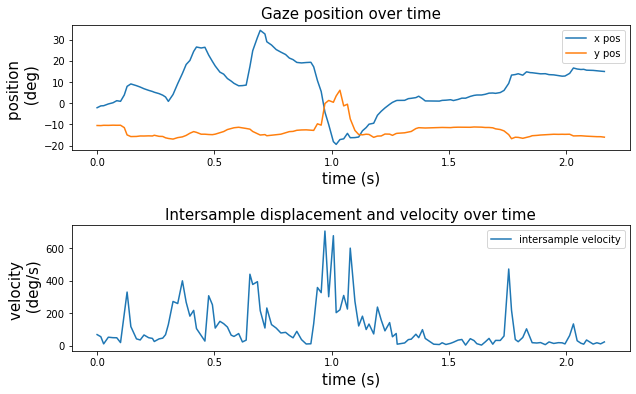

In [14]:
#visual check of converted deg gaze position

print(labels[-1])

plt.figure(figsize=(10,6)) # Set the plot size

# Plot position
plt.subplot(2,1,1)
plt.plot(time[i:i+window]-time[i], x_deg, label = 'x pos')
plt.plot(time[i:i+window]-time[i], y_deg, label = 'y pos')
# plt.plot(time[i:i+window], isd, label='intersample displacement')
plt.ylabel('position \n (deg)', fontsize=15)
plt.xlabel('time (s)', fontsize = 15)
plt.legend(loc='upper right')
plt.title('Gaze position over time', fontsize=15)

# Plot velocity
plt.subplot(2,1,2)
plt.plot(time[i:i+window]-time[i], isv, label='intersample velocity')
plt.ylabel('velocity \n (deg/s)', fontsize=15)
plt.xlabel('time (s)', fontsize=15)
plt.legend(loc='upper right')
plt.title('Intersample velocity over time', fontsize = 15)

plt.subplots_adjust(hspace=0.6)

plt.show()

## Combine data into one dataframe

In [15]:
x_deg_headers = [str(FEATS[0]+str(i+1)) for i in range(window)]
y_deg_headers = [str(FEATS[1]+str(i+1)) for i in range(window)]
isd_headers   = [str(FEATS[2]+str(i+1)) for i in range(window)]
isv_headers   = [str(FEATS[3]+str(i+1)) for i in range(window)]
test_headers  = ['steps_to_kitchen', 'sec_to_kitchen', 'amps_motor', 'amps_process']
feature_headers = x_deg_headers + y_deg_headers + isd_headers + isv_headers + test_headers
label_headers = ['subID', 'task', 'vision_loss']
feat2_headers = ['x_mean', 'x_std', 'y_mean', 'y_std', 'd_mean', 'd_std', 'v_mean', 'v_std']

# labels
Y = pd.DataFrame(data=np.array(labels), columns=label_headers)
# features
X = pd.DataFrame(data=np.array(features), columns=feature_headers)

X2 = pd.DataFrame(data=np.array(feats2), columns=feat2_headers)

feats2_standard = []

# standardize the features
mean_x, std_x = np.average(x_all), np.std(x_all)
mean_y, std_y = np.average(y_all), np.std(y_all)
mean_d, std_d = np.average(d_all), np.std(d_all)
mean_v, std_v = np.average(v_all), np.std(v_all)
for index, row in X.iterrows():
    X.iloc[index][:SEQ_LENGTH] = (row[:SEQ_LENGTH]-mean_x)/std_x
    X.iloc[index][SEQ_LENGTH:SEQ_LENGTH*2] = (row[SEQ_LENGTH:SEQ_LENGTH*2]-mean_y)/std_y
    X.iloc[index][SEQ_LENGTH*2:SEQ_LENGTH*3] = (row[SEQ_LENGTH*2:SEQ_LENGTH*3]-mean_d)/std_d
    X.iloc[index][SEQ_LENGTH*3:SEQ_LENGTH*4] = (row[SEQ_LENGTH*3:SEQ_LENGTH*4]-mean_v)/std_v
    
    # create new features of the means and standard deviations for each normalized sample
    xs_mu = np.average(X.iloc[index][:SEQ_LENGTH])
    xs_std = np.std(X.iloc[index][:SEQ_LENGTH])
    ys_mu = np.average(X.iloc[index][SEQ_LENGTH:SEQ_LENGTH*2])
    ys_std = np.std(X.iloc[index][SEQ_LENGTH:SEQ_LENGTH*2])
    ds_mu = np.average(X.iloc[index][SEQ_LENGTH*2:SEQ_LENGTH*3])
    ds_std = np.std(X.iloc[index][SEQ_LENGTH*2:SEQ_LENGTH*3])
    vs_mu = np.average(X.iloc[index][SEQ_LENGTH*3:SEQ_LENGTH*4])
    vs_std = np.std(X.iloc[index][SEQ_LENGTH*3:SEQ_LENGTH*4])
    
    feats2_standard.append([xs_mu, xs_std, ys_mu, ys_std, ds_mu, ds_std, vs_mu, vs_std])

# Track distribution parameters of standardized gaze data for comparison purposes
feat2_standard_headers = ['xs_mean', 'xs_std', 'ys_mean', 'ys_std', 'ds_mean', 'ds_std', 'vs_mean', 'vs_std']
X3 = pd.DataFrame(data=np.array(feats2_standard), columns=feat2_standard_headers)    
    
print("before:\n", Y.vision_loss.value_counts())
    
# Make CVL and PVL of equal length by randomly dropping datasets of whichever has more
if len(Y[Y.vision_loss=='CVL']) > len(Y[Y.vision_loss=='PVL']):
    num_to_drop = len(Y[Y.vision_loss=='CVL'])-len(Y[Y.vision_loss=='PVL'])
    CVL_indices = Y.index[Y.vision_loss=='CVL'].tolist()
    rows_to_drop = np.random.choice(CVL_indices, num_to_drop, replace=False)
    X = X[~X.index.isin(rows_to_drop)]
    X2, X3 = X2[~X2.index.isin(rows_to_drop)], X3[~X3.index.isin(rows_to_drop)]
    Y = Y[~Y.index.isin(rows_to_drop)]
elif len(Y[Y.vision_loss=='PVL']) > len(Y[Y.vision_loss=='CVL']):
    num_to_drop = len(Y[Y.vision_loss=='PVL'])-len(Y[Y.vision_loss=='CVL'])
    PVL_indices = Y.index[Y.vision_loss=='PVL'].tolist()
    rows_to_drop = np.random.choice(PVL_indices, num_to_drop, replace=False)
    X = X[~X.index.isin(rows_to_drop)]
    X2, X3 = X2[~X2.index.isin(rows_to_drop)], X3[~X3.index.isin(rows_to_drop)]
    Y = Y[~Y.index.isin(rows_to_drop)]

print("after:\n", Y.vision_loss.value_counts())
    
# combine labels and features
df = pd.concat([Y, X], axis=1)

# do the same for the distribution features
df2 = pd.concat([Y, X2, X3], axis=1)

df.head(10)

before:
 PVL    7817
CVL    5603
Name: vision_loss, dtype: int64
after:
 CVL    5603
PVL    5603
Name: vision_loss, dtype: int64


,subID,task,vision_loss,x_deg1,x_deg2,x_deg3,x_deg4,x_deg5,x_deg6,x_deg7,...,isv127,isv128,isv129,isv130,isv131,isv132,steps_to_kitchen,sec_to_kitchen,amps_motor,amps_process
0,P2,sandwich,CVL,1.268203,1.280564,1.197623,1.009471,0.941910,0.904355,0.874632,...,-0.542383,-0.587449,-0.412932,-0.529949,-0.518633,-0.568042,-0.498856,-0.501699,1.295624,1.976659
1,P2,sandwich,CVL,0.832926,0.846608,0.854062,0.861988,0.859252,0.860479,0.865102,...,-0.444822,-0.521838,-0.557488,-0.453517,-0.559753,-0.237702,-0.498856,-0.501699,1.295624,1.976659
2,P2,sandwich,CVL,0.986353,1.025795,1.035797,1.048819,1.108925,1.126382,1.182903,...,-0.590100,-0.526695,-0.418896,-0.552186,-0.246852,-0.507307,-0.498856,-0.501699,1.295624,1.976659
3,P2,sandwich,CVL,2.295300,2.289544,2.236042,2.369277,2.342385,2.294450,2.328419,...,-0.491877,-0.454882,-0.554283,-0.572562,-0.489117,-0.279227,-0.498856,-0.501699,1.295624,1.976659
4,P2,sandwich,CVL,2.408908,2.395792,2.391640,2.391734,2.396830,2.404945,2.407398,...,-0.324343,-0.150300,-0.078863,0.108395,-0.504103,-0.292512,-0.498856,-0.501699,1.295624,1.976659
5,P2,sandwich,CVL,2.587246,2.581490,2.634991,2.623951,2.611590,2.603381,2.665469,...,-0.211490,-0.318160,-0.115581,0.432127,-0.243350,0.163016,-0.498856,-0.501699,1.295624,1.976659
6,P2,sandwich,CVL,2.763414,2.807951,2.816160,2.816727,2.818331,2.840411,2.838240,...,-0.568507,-0.587825,-0.286527,-0.438877,-0.494241,-0.218522,-0.498856,-0.501699,1.295624,1.976659
7,P2,sandwich,CVL,2.600456,2.610647,2.613949,2.522704,2.265860,2.138947,2.043739,...,2.946173,2.107851,3.547058,2.204512,0.109601,4.132165,-0.498856,-0.501699,1.295624,1.976659
8,P2,sandwich,CVL,2.163858,2.153667,2.193109,2.212075,2.227927,2.285958,2.325872,...,0.182295,-0.331712,-0.055094,-0.327112,-0.264825,-0.064412,-0.498856,-0.501699,1.295624,1.976659
9,P2,sandwich,CVL,1.372470,1.369733,1.412855,1.452297,1.474094,1.490230,1.429746,...,1.249597,1.965748,1.109730,0.329669,2.405489,2.024514,-0.498856,-0.501699,1.295624,1.976659


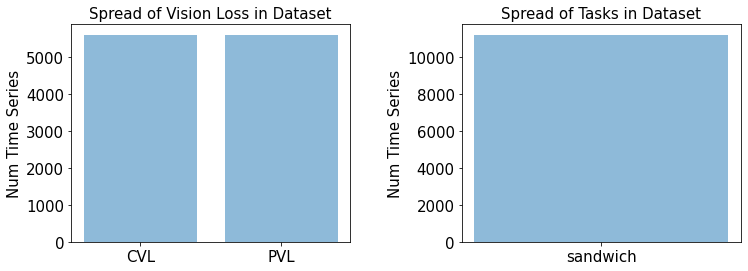

In [16]:
# visualize the spread of data in vision loss and task

plt.figure(figsize=(12,4)) # Set the plot size

objects = df.vision_loss.value_counts()
targets = list(objects.index)
counts = objects.values
y_pos = np.arange(len(targets))

plt.subplot(1,2,1)
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, targets, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Num Time Series', fontsize=15)
plt.title('Spread of Vision Loss in Dataset', fontsize=15)

objects = df.task.value_counts()
targets = list(objects.index)
counts = objects.values
y_pos = np.arange(len(targets))

plt.subplot(1,2,2)
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, targets, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Num Time Series', fontsize=15)
plt.title('Spread of Tasks in Dataset', fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.show()

## Visualizing the features

Below we choose a random subset of the training data, and visualize the 4 types of available features:
* x_deg (position)
* y_deg (position)
* isd   (intersample displacement)
* isv   (intersample velocity)

Try to run it a few times to try and get an understanding of how the features differ from participant-task to participant-task.

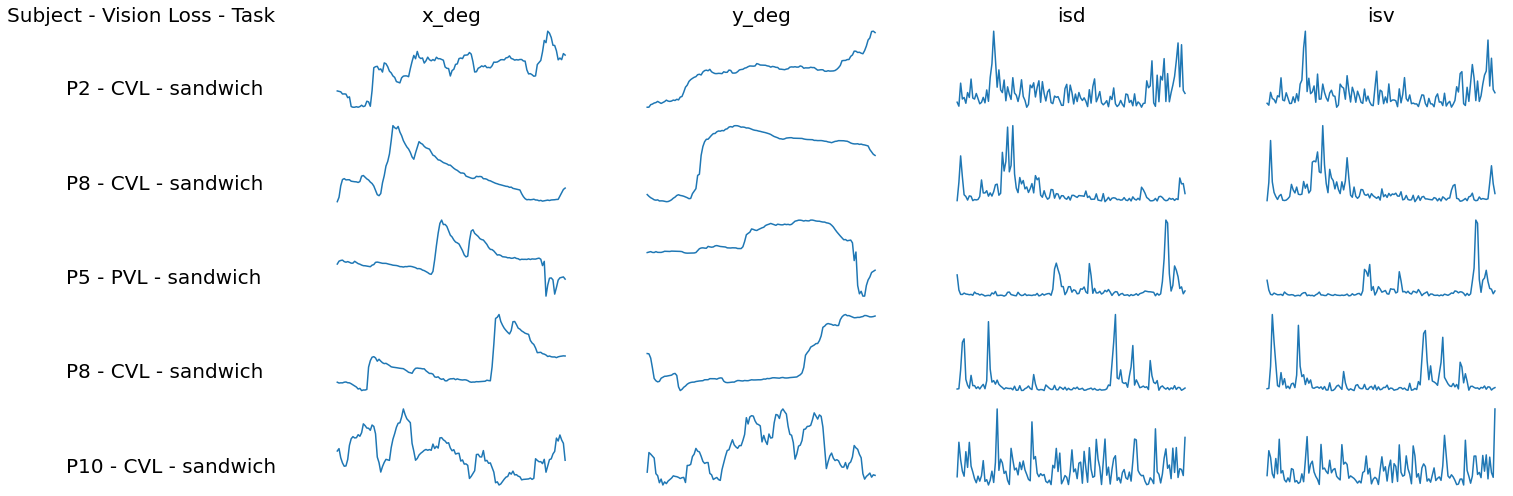

In [17]:
# Extract labels and features
y = Y.values
subID = y[:, 0:1]
task = y[:, 1:2]
loss = y[:, 2:]
x = X.values
x_deg = x[:, :SEQ_LENGTH]
y_deg = x[:, SEQ_LENGTH:SEQ_LENGTH*2]
isd   = x[:, SEQ_LENGTH*2:SEQ_LENGTH*3]
isv   = x[:, SEQ_LENGTH*3:SEQ_LENGTH*4]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(df)), amount)):
    ax = plt.subplot(amount,5,1+i*5)
    txt = ax.text(0.2, 0.2, str(subID[idx][0]+' - '+loss[idx][0]+' - '+task[idx][0]), fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Subject - Vision Loss - Task', fontsize=20)
    plt.subplot(amount,5,2+i*5)
    plt.plot(x_deg[idx])
    if i == 0:
        plt.title(FEATS[0], fontsize=20)
    plt.axis('off')
    plt.subplot(amount,5,3+i*5)
    plt.plot(y_deg[idx])
    if i == 0:
        plt.title(FEATS[1], fontsize=20)
    plt.axis('off')
    plt.subplot(amount,5,4+i*5)
    plt.plot(isd[idx])
    if i == 0:
        plt.title(FEATS[2], fontsize=20)
    plt.axis('off')
    plt.subplot(amount,5,5+i*5)
    plt.plot(isv[idx])
    if i == 0:
        plt.title(FEATS[3], fontsize=20)
    plt.axis('off')
    

plt.tight_layout()
plt.show()

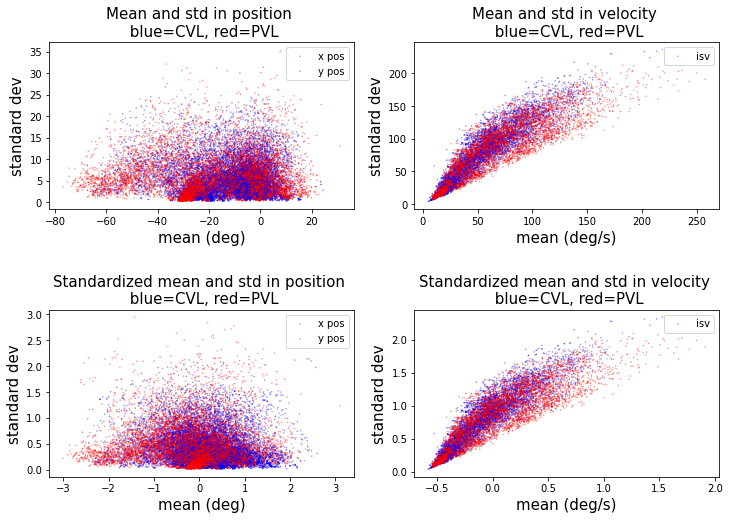

In [18]:
#visual check of converted deg gaze position

colors = []
for _ in loss:
    for vl in _:
        if vl == 'CVL': colors.append('blue')
        elif vl == 'PVL': colors.append('red')
x2 = X2.values

x_mu, x_std = x2[:, 0].tolist(), x2[:, 1].tolist()
y_mu, y_std = x2[:, 2].tolist(), x2[:, 3].tolist()
d_mu, d_std = x2[:, 4].tolist(), x2[:, 5].tolist()
v_mu, v_std = x2[:, 6].tolist(), x2[:, 7].tolist()

plt.figure(figsize=(12,8)) # Set the plot size

# Plot position means vs stds
plt.subplot(2,2,1)
plt.scatter(x_mu, x_std, color=colors, label = 'x pos', s=0.2, alpha=0.5)
plt.scatter(y_mu, y_std, color=colors, label = 'y pos', s=0.2, alpha=0.5)
# plt.plot(time[i:i+window], isd, label='intersample displacement')
plt.ylabel('standard dev', fontsize=15)
plt.xlabel('mean (deg)', fontsize = 15)
plt.legend(loc='upper right')
plt.title('Mean and std in position \n blue=CVL, red=PVL', fontsize=15)

# Plot velocity means vs stds
plt.subplot(2,2,2)
#plt.scatter(d_mu, d_std, color=colors, label = 'isd', s=0.2, alpha=0.5)
plt.scatter(v_mu, v_std, color=colors, label = 'isv', s=0.2, alpha=0.5)
plt.ylabel('standard dev', fontsize=15)
plt.xlabel('mean (deg/s)', fontsize=15)
plt.legend(loc='upper right')
plt.title('Mean and std in velocity \n blue=CVL, red=PVL', fontsize = 15)

### standardized distributions ###
x3 = X3.values

xs_mu, xs_std = x3[:, 0].tolist(), x3[:, 1].tolist()
ys_mu, ys_std = x3[:, 2].tolist(), x3[:, 3].tolist()
ds_mu, ds_std = x3[:, 4].tolist(), x3[:, 5].tolist()
vs_mu, vs_std = x3[:, 6].tolist(), x3[:, 7].tolist()

# Plot position means vs stds
plt.subplot(2,2,3)
plt.scatter(xs_mu, xs_std, color=colors, label = 'x pos', s=0.2, alpha=0.5)
plt.scatter(ys_mu, ys_std, color=colors, label = 'y pos', s=0.2, alpha=0.5)
# plt.plot(time[i:i+window], isd, label='intersample displacement')
plt.ylabel('standard dev', fontsize=15)
plt.xlabel('mean (deg)', fontsize = 15)
plt.legend(loc='upper right')
plt.title('Standardized mean and std in position \n blue=CVL, red=PVL', fontsize=15)

# Plot velocity means vs stds
plt.subplot(2,2,4)
#plt.scatter(ds_mu, ds_std, color=colors, label = 'isd', s=0.2, alpha=0.5)
plt.scatter(vs_mu, vs_std, color=colors, label = 'isv', s=0.2, alpha=0.5)
plt.ylabel('standard dev', fontsize=15)
plt.xlabel('mean (deg/s)', fontsize=15)
plt.legend(loc='upper right')
plt.title('Standardized mean and std in velocity \n blue=CVL, red=PVL', fontsize = 15)


plt.subplots_adjust(hspace=0.6)

plt.show()

## Split dataset into testing and training sets

In [19]:
# Use onehot encoding for vision loss type and for task
onehot_vl = pd.get_dummies(Y, columns=['vision_loss'], prefix="Loss")
onehot_task = pd.get_dummies(Y, columns=['task'], prefix="Task")
is_cvl = onehot_vl['Loss_CVL'].to_numpy()

In [20]:
np.random.seed(5)

# Randomly choose one participant with CVL and one with PVL for the test set
valid_cvls = [key for (key, value) in valid_participants.items() if value == 'CVL']
valid_pvls = [key for (key, value) in valid_participants.items() if value == 'PVL']
test_participants = {str(np.random.choice(valid_cvls)):'CVL', str(np.random.choice(valid_pvls)):'PVL'}

# Exclude the test participants from the training set (and therefore validation set)
temp = valid_participants.copy()
for (key, value) in test_participants.items():
    temp.pop(key)
train_participants = temp

print("Train Participants:", train_participants)
print("Test Participants:", test_participants)

# Show the vision loss split between train and test datasets 
print(f"Participants in train set with CVL: {list(train_participants.values()).count('CVL')}/{len(train_participants.keys())}")
print(f"Participants in test set with CVL: {list(test_participants.values()).count('CVL')}/{len(test_participants.keys())}")

Train Participants: {'P2': 'CVL', 'P6': 'CVL', 'P8': 'CVL', 'P10': 'CVL', 'P14': 'PVL', 'P15': 'PVL', 'P22': 'PVL', 'P24': 'PVL'}
Test Participants: {'P9': 'CVL', 'P5': 'PVL'}
Participants in train set with CVL: 4/8
Participants in test set with CVL: 1/2


In [34]:
df_train = df2[df2['subID'].isin(list(train_participants.keys()))]
df_test = df2[df2['subID'].isin(list(test_participants.keys()))]

x_train = df_train.iloc[:,3:11]
x_test  = df_test.iloc[:, 3:11]
y_train = df_train.iloc[:,:3]
y_test  = df_test.iloc[:, :3]

onehot_vl_train = pd.get_dummies(y_train, columns=['vision_loss'], prefix="Loss")
is_cvl_train = onehot_vl_train['Loss_CVL'].to_numpy()
onehot_vl_test = pd.get_dummies(y_test, columns=['vision_loss'], prefix="Loss")
is_cvl_test = onehot_vl_test['Loss_CVL'].to_numpy()

y_train = is_cvl_train
y_test = is_cvl_test

In [35]:
# df_train = df[df['subID'].isin(list(train_participants.keys()))]
# df_test = df[df['subID'].isin(list(test_participants.keys()))]

# x_train = df_train.iloc[:,3:]
# x_test  = df_test.iloc[:, 3:]
# y_train = df_train.iloc[:,:3]
# y_test  = df_test.iloc[:, :3]

# onehot_vl_train = pd.get_dummies(y_train, columns=['vision_loss'], prefix="Loss")
# is_cvl_train = onehot_vl_train['Loss_CVL'].to_numpy()
# onehot_vl_test = pd.get_dummies(y_test, columns=['vision_loss'], prefix="Loss")
# is_cvl_test = onehot_vl_test['Loss_CVL'].to_numpy()

# y_train = is_cvl_train
# y_test = is_cvl_test

In [36]:
# Use this instead of the above two cells when you want the train and test set to be randomly split from the
# same dataframe (with all participants).

# train holds both X (input) and t (target/truth)
#x_train, x_test, y_train, y_test = train_test_split(X, is_cvl, test_size = 0.2, random_state = 42, shuffle = True)

## Load data into the dataloader

In [37]:
# Create data of type dict
# train holds both X (input) and t (target/truth)
data = data_utils.load_data(x_train, y_train, x_test, y_test)
# Visualize the size of the dimensions of the data and ensure train and test are similar in stats
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\t"+FEATS2[0]+"\t%s\t%f" % (data.train[FEATS2[0]].shape, data.train[FEATS2[0]].mean()))
print("\t"+FEATS2[1]+"\t%s\t%f" % (data.train[FEATS2[1]].shape, data.train[FEATS2[1]].mean()))
print("\t"+FEATS2[2]+"\t%s\t%f" % (data.train[FEATS2[2]].shape, data.train[FEATS2[2]].mean()))
print("\t"+FEATS2[3]+"\t%s\t%f" % (data.train[FEATS2[3]].shape, data.train[FEATS2[3]].mean()))
print("\t"+TEST_FEATS2[0]+"\t%s\t%f" % (data.train[TEST_FEATS2[0]].shape, data.train[TEST_FEATS2[0]].mean()))
print("\t"+TEST_FEATS2[1]+"\t%s\t%f" % (data.train[TEST_FEATS2[1]].shape, data.train[TEST_FEATS2[1]].mean()))
print("\t"+TEST_FEATS2[2]+"\t%s\t%f" % (data.train[TEST_FEATS2[2]].shape, data.train[TEST_FEATS2[2]].mean()))
print("\t"+TEST_FEATS2[3]+"\t%s\t%f" % (data.train[TEST_FEATS2[3]].shape, data.train[TEST_FEATS2[3]].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encisdode ts to (batch_size, num_classes)")
print("TEST")
print("\t"+FEATS2[0]+"\t%s\t%f" % (data.test[FEATS2[0]].shape, data.test[FEATS2[0]].mean())) 
print("\t"+FEATS2[1]+"\t%s\t%f" % (data.test[FEATS2[1]].shape, data.test[FEATS2[1]].mean()))
print("\t"+FEATS2[2]+"\t%s\t%f" % (data.test[FEATS2[2]].shape, data.test[FEATS2[2]].mean()))
print("\t"+FEATS2[3]+"\t%s\t%f" % (data.test[FEATS2[3]].shape, data.test[FEATS2[3]].mean()))
print("\t"+TEST_FEATS2[0]+"\t%s\t%f" % (data.test[TEST_FEATS2[0]].shape, data.test[TEST_FEATS2[0]].mean())) 
print("\t"+TEST_FEATS2[1]+"\t%s\t%f" % (data.test[TEST_FEATS2[1]].shape, data.test[TEST_FEATS2[1]].mean()))
print("\t"+TEST_FEATS2[2]+"\t%s\t%f" % (data.test[TEST_FEATS2[2]].shape, data.test[TEST_FEATS2[2]].mean()))
print("\t"+TEST_FEATS2[3]+"\t%s\t%f" % (data.test[TEST_FEATS2[3]].shape, data.test[TEST_FEATS2[3]].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 9269
	1000 of 9269
	2000 of 9269
	3000 of 9269
	4000 of 9269
	5000 of 9269
	6000 of 9269
	7000 of 9269
	8000 of 9269
	9000 of 9269
Loading test data
	0 of 1937
	1000 of 1937

@@@Shape checking of data sets@@@
TRAIN
	x_mu	(9269,)	-1.123948
	x_std	(9269,)	6.080778
	y_mu	(9269,)	-27.864494
	y_std	(9269,)	5.878515
	d_mu	(9269,)	0.962251
	d_std	(9269,)	1.255050
	v_mu	(9269,)	62.988827
	v_std	(9269,)	81.033218
	ts	 9269
	while training, batch_generator will onehot encisdode ts to (batch_size, num_classes)
TEST
	x_mu	(1937,)	-5.670269
	x_std	(1937,)	5.616890
	y_mu	(1937,)	-19.795069
	y_std	(1937,)	4.104341
	d_mu	(1937,)	0.857321
	d_std	(1937,)	1.299717
	v_mu	(1937,)	63.069813
	v_std	(1937,)	92.944580
	ids	1937


### Batches and Validation
Batch size is the number of samples sent to the model at a time.

In [38]:
dummy_batch_gen = data_utils.batch_generator(data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\tx_mean,", train_batch[FEATS2[0]].shape)
print("\tx_std,", train_batch[FEATS2[1]].shape)
print("\ty_mean,", train_batch[FEATS2[2]].shape)
print("\ty_std,", train_batch[FEATS2[3]].shape)
print("\td_mean,", train_batch[FEATS2[0]].shape)
print("\td_std,", train_batch[FEATS2[1]].shape)
print("\tv_mean,", train_batch[FEATS2[2]].shape)
print("\tv_std,", train_batch[FEATS2[3]].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\tx_mean,", valid_batch[FEATS2[0]].shape)
print("\tx_std,", valid_batch[FEATS2[1]].shape)
print("\ty_mean,", valid_batch[FEATS2[2]].shape)
print("\ty_std,", valid_batch[FEATS2[3]].shape)
print("\td_mean,", valid_batch[FEATS2[0]].shape)
print("\td_std,", valid_batch[FEATS2[1]].shape)
print("\tv_mean,", valid_batch[FEATS2[2]].shape)
print("\tv_std,", valid_batch[FEATS2[3]].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\tx_mean,", test_batch[FEATS2[0]].shape)
print("\tx_std,", test_batch[FEATS2[1]].shape)
print("\ty_mean,", test_batch[FEATS2[2]].shape)
print("\ty_std,", test_batch[FEATS2[3]].shape)
print("\td_mean,", test_batch[FEATS2[0]].shape)
print("\td_std,", test_batch[FEATS2[1]].shape)
print("\tv_mean,", test_batch[FEATS2[2]].shape)
print("\tv_std,", test_batch[FEATS2[3]].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	x_mean, (20, 132)
	x_std, (20, 132)
	y_mean, (20, 132)
	y_std, (20, 132)
	d_mean, (20, 132)
	d_std, (20, 132)
	v_mean, (20, 132)
	v_std, (20, 132)
	ts, (20, 2)

VALID
	x_mean, (20, 132)
	x_std, (20, 132)
	y_mean, (20, 132)
	y_std, (20, 132)
	d_mean, (20, 132)
	d_std, (20, 132)
	v_mean, (20, 132)
	v_std, (20, 132)
	ts, (20, 2)

TEST
	x_mean, (20, 132)
	x_std, (20, 132)
	y_mean, (20, 132)
	y_std, (20, 132)
	d_mean, (20, 132)
	d_std, (20, 132)
	v_mean, (20, 132)
	v_std, (20, 132)
	ids, 20


## Build the model

### Model: CNN

In [66]:
class Linear_to_LSTM(nn.Module):
    def __init__(self):
        super(Linear_to_LSTM, self).__init__()
        
        # Linear layer for inputs
#         self.l_in = Linear(SEQ_LENGTH, HIDDEN_SIZE)
        
        # Conv1d layer
        self.conv1d = Conv1d(in_channels = NUM_FEATS2,
                             out_channels = NUM_FEATS2,
                             kernel_size = 4,
                             stride = 2,
                             padding = 2)
        
        # Output linear layer
        self.l_out = Linear(in_features = NUM_FEATS2,
                            out_features = NUM_CLASSES,
                            bias = False)

        # Functions to help generalize the model
        self.dropout = Dropout(p = 0.6)
        self.batchnorm1d = BatchNorm1d(NUM_FEATS2)
        
    def forward(self, x_mu, x_std, y_mu, y_std, d_mu, d_std, v_mu, v_std):
        features = []
        output = {}
        
#         # First run a linear layer on all features individually for feature extraction
#         x_mu, x_std = relu(self.l_in(x_mu)), relu(self.l_in(x_std))
#         y_mu, y_std = relu(self.l_in(y_mu)), relu(self.l_in(y_std))
#         d_mu, d_std = relu(self.l_in(d_mu)), relu(self.l_in(d_std))
#         v_mu, v_std = relu(self.l_in(v_mu)), relu(self.l_in(v_std))
        
        
        # Stack along channels
        stacked = torch.stack((x_mu, x_std, y_mu, y_std, d_mu, d_std, v_mu, v_std), dim=2)

        ## Then run a convolutional 1d network
        stacked = stacked.permute(0,2,1)
        x_cnn = self.conv1d(stacked)
        x_cnn = relu(x_cnn)
        x_cnn = self.dropout(x_cnn)
        
        # Change dimensions s.t. the features can be used in the final FFNN output layer
        features_cnn = x_cnn.reshape(BATCH_SIZE, -1)
        features.append(features_cnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        features_final = self.batchnorm1d(features_final)
        
        output['out'] = softmax(self.l_out(features_final), dim=1)
        
        return output
    
net = Linear_to_LSTM()

## Build the cost function

In [67]:
criterion = CrossEntropyLoss()

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)#, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [3000, 4000, 5000])

## Unit Test
Run this to ensure the model has no shape issues.

In [68]:
_feature_shape = (BATCH_SIZE, SEQ_LENGTH2)

def randnorm(n):
    return np.random.normal(loc = 0, scale = 1, size = n).astype('float32')

# dummy data
_x_mu  = Variable(torch.from_numpy(randnorm(_feature_shape)))
_x_std = Variable(torch.from_numpy(randnorm(_feature_shape)))
_y_mu  = Variable(torch.from_numpy(randnorm(_feature_shape)))
_y_std = Variable(torch.from_numpy(randnorm(_feature_shape)))
_d_mu    = Variable(torch.from_numpy(randnorm(_feature_shape)))
_d_std   = Variable(torch.from_numpy(randnorm(_feature_shape)))
_v_mu    = Variable(torch.from_numpy(randnorm(_feature_shape)))
_v_std   = Variable(torch.from_numpy(randnorm(_feature_shape)))

# test the forward pass
output = net(_x_mu, _x_std, _y_mu, _y_std, _d_mu, _d_std, _v_mu, _v_std)
print(f"Unit Test: output: {output['out'].shape}")

Unit Test: output: torch.Size([20, 2])


## Train the Model

In [69]:
# Function to get label
def get_labels(batch):
    #print("batch:", Variable(torch.from_numpy(batch['ts']).long()))
    return Variable(torch.from_numpy(batch['ts']).long())

# Function to get input
def get_input(batch):
    return {
        FEATS2[0]: Variable(torch.from_numpy(batch[FEATS2[0]])),
        FEATS2[1]: Variable(torch.from_numpy(batch[FEATS2[1]])),
        FEATS2[2]: Variable(torch.from_numpy(batch[FEATS2[2]])),
        FEATS2[3]: Variable(torch.from_numpy(batch[FEATS2[3]])),
        TEST_FEATS2[0]: Variable(torch.from_numpy(batch[TEST_FEATS2[0]])),
        TEST_FEATS2[1]: Variable(torch.from_numpy(batch[TEST_FEATS2[1]])),
        TEST_FEATS2[2]: Variable(torch.from_numpy(batch[TEST_FEATS2[2]])),
        TEST_FEATS2[3]: Variable(torch.from_numpy(batch[TEST_FEATS2[3]]))
    }


def get_numpy(x):
    return x.data.numpy()

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

def get_targets(batch):
    print("target:", Variable(torch.from_numpy(batch['ts']).long()))
    return Variable(torch.FloatTensor(batch['ts']).long())

In [ ]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 5000 # number of epochs
log_every = 200
eval_every = 100

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=BATCH_SIZE,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       num_features=SEQ_LENGTH2,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

avg_loss = []
avg_accs = []

# Print the network
print(net)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        # Do the validation
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            if num != BATCH_SIZE:
                continue
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()

    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)

    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

    # Log i figure
    if i % log_every == 0:
        
        #clear_output(wait=True)

        avg_loss.append(np.average(train_loss))
        avg_accs.append(np.average(train_accs))
        print("Avg train, it: {} loss: {:.2f} accs: {:.2f}".format(i, avg_loss[-1], avg_accs[-1]))
    
    # Only plot at the end of training
    if i % max_iter == 0 and i != 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()

    if max_iter < i:
        break

Linear_to_LSTM(
  (conv1d): Conv1d(8, 8, kernel_size=(4,), stride=(2,), padding=(2,))
  (l_out): Linear(in_features=8, out_features=2, bias=False)
  (dropout): Dropout(p=0.6, inplace=False)
  (batchnorm1d): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Avg train, it: 0 loss: 0.72 accs: 0.35
Avg train, it: 200 loss: 0.69 accs: 0.53
Avg train, it: 400 loss: 0.68 accs: 0.54
Avg train, it: 600 loss: 0.68 accs: 0.55
Avg train, it: 800 loss: 0.68 accs: 0.56
Avg train, it: 1000 loss: 0.67 accs: 0.57
Avg train, it: 1200 loss: 0.67 accs: 0.58
Avg train, it: 1400 loss: 0.67 accs: 0.58
Avg train, it: 1600 loss: 0.67 accs: 0.58
Avg train, it: 1800 loss: 0.67 accs: 0.58
Avg train, it: 2000 loss: 0.67 accs: 0.58
Avg train, it: 2200 loss: 0.67 accs: 0.58
Avg train, it: 2400 loss: 0.67 accs: 0.58
Avg train, it: 2600 loss: 0.67 accs: 0.59
Avg train, it: 2800 loss: 0.67 accs: 0.59
Avg train, it: 3000 loss: 0.67 accs: 0.58
Avg train, it: 3200 loss: 0.67 accs: 0.58
Avg t

## Test the model

In [ ]:
test_accs = []
cvl_preds, cvl_accs = [], []
pvl_preds, pvl_accs = [], []
preds, targs = [], []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch_test, num in batch_gen.gen_test():
        if num != BATCH_SIZE:
            continue
        output = net(**get_input(batch_test))
        targets = torch.max(get_labels(batch_test), 1)[1]  # 1 is cvl, 0 is pvl
        predictions = torch.max(output['out'], 1)[1]
        pred_isCorrect = torch.eq(predictions, targets)
        batch_acc = torch.mean(pred_isCorrect.float())
        test_accs.append(float(batch_acc.item()))
        
        pred_accs = torch.max(output['out'], 1)[0]
        pred_accs = pred_accs.tolist()
        
        # for plotting purposes
        targets = targets.tolist()
        predictions = predictions.tolist()
        targs.extend(targets)
        preds.extend(predictions)

        # for results    
        for i in range(len(targets)):
            if targets[i] == 1:
                if predictions[i] == 1:
                    cvl_preds.append(True)
                    cvl_accs.append(pred_accs[i])
                else:
                    cvl_preds.append(False)
            elif targets[i] == 0:
                if predictions[i] == 0:
                    pvl_preds.append(True)
                    pvl_accs.append(pred_accs[i])
                else:
                    pvl_preds.append(False)


print("Overall accuracy of test:", np.round(np.average(test_accs)*100,2),'%')
print(f"CVL classified correctly {np.round(np.average(cvl_preds)*100,1)}% of the time with an average accuracy of {np.round(np.average(cvl_accs)*100,1)}%.")
print(f"PVL classified correctly {np.round(np.average(pvl_preds)*100,1)}% of the time with an average accuracy of {np.round(np.average(pvl_accs)*100,1)}%.")

# visualize results in a confusion matrix

# first remap onehot to classes
label = {0:'PVL', 1:'CVL'}
for i in range(len(targs)):
    if targs[i] == 1:
        targs[i] = 'CVL'
    elif targs[i] == 0:
        targs[i] = 'PVL'
for i in range(len(preds)):
    if preds[i] == 1:
        preds[i] = 'CVL'
    elif preds[i] == 0:
        preds[i] = 'PVL'
        
plot_df = pd.DataFrame({'Target':targs, 'Prediction':preds})
confusion_matrix = pd.crosstab(plot_df['Prediction'], plot_df['Target'], rownames=['Prediction'], colnames=['Target'])
confusion_matrix = confusion_matrix.apply(lambda x: x/x.sum(), axis=0)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

Print the model parameteres to remember what contributed to the above results.

In [64]:
print(f"BATCH_SIZE    {BATCH_SIZE}")
print(f"LEARNING_RATE {LEARNING_RATE}")
print(f"HIDDEN_SIZE   {HIDDEN_SIZE}")
print(f"SEQ_LENGTH    {SEQ_LENGTH}")
print(f"STEP_SIZE     {STEP_SIZE}")

BATCH_SIZE    20
LEARNING_RATE 0.001
HIDDEN_SIZE   100
SEQ_LENGTH    132
STEP_SIZE     0.2
